In [71]:
import numpy as np 
import pandas as pd
import time
import random

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.style.use("seaborn-pastel")

%matplotlib inline


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from warnings import filterwarnings
filterwarnings('ignore', category=ConvergenceWarning)  # Ignoring convergence warnings


# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

# Preprocessing

In [72]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
df = pd.DataFrame(wine.data.original)

#set seeds to get reproducible results
np.random.seed(3)
random.seed(3)
tf.random.set_seed(3)

df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


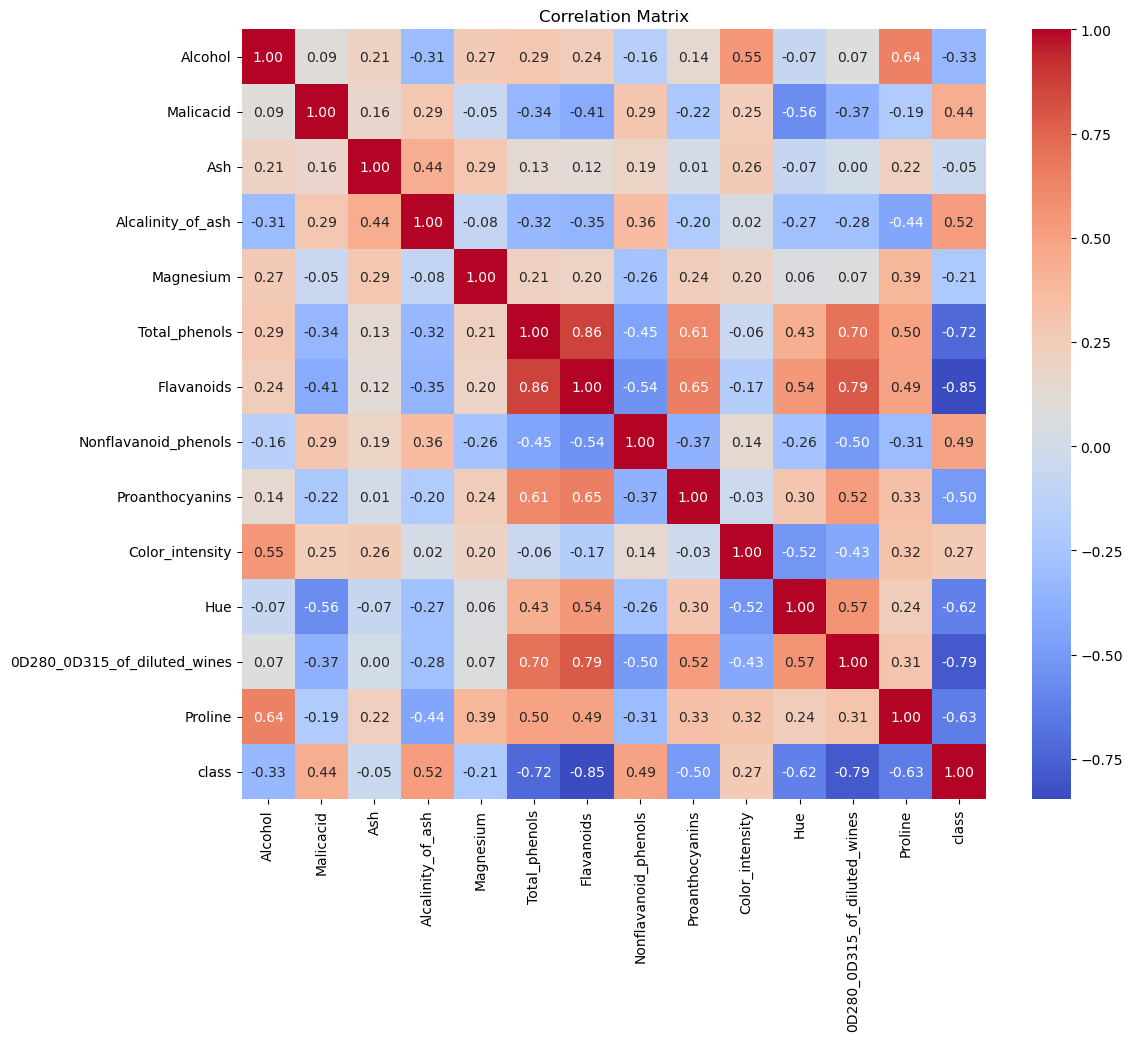

In [73]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [74]:
threshold = 0.7
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1.0)
correlated_variables = [pair for pair in highly_correlated if any(highly_correlated[pair])]
print(correlated_variables)

['Total_phenols', 'Flavanoids', '0D280_0D315_of_diluted_wines', 'class']


Correlated variables impact logistic regression outputs. We will drop these features from the data.

In [75]:
#Dropping variables listed above that are correlated
df = df.drop(['Total_phenols', 'Flavanoids', '0D280_0D315_of_diluted_wines'], axis=1)
#check to verify
df

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Proline,class
0,14.23,1.71,2.43,15.6,127,0.28,2.29,5.64,1.04,1065,1
1,13.20,1.78,2.14,11.2,100,0.26,1.28,4.38,1.05,1050,1
2,13.16,2.36,2.67,18.6,101,0.30,2.81,5.68,1.03,1185,1
3,14.37,1.95,2.50,16.8,113,0.24,2.18,7.80,0.86,1480,1
4,13.24,2.59,2.87,21.0,118,0.39,1.82,4.32,1.04,735,1
...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,0.52,1.06,7.70,0.64,740,3
174,13.40,3.91,2.48,23.0,102,0.43,1.41,7.30,0.70,750,3
175,13.27,4.28,2.26,20.0,120,0.43,1.35,10.20,0.59,835,3
176,13.17,2.59,2.37,20.0,120,0.53,1.46,9.30,0.60,840,3


In [76]:
def preprocessor(df):
    """
    Preprocesses the dataset by encoding categorical features using LabelEncoder

    Args:
        df (pandas.DataFrame): Input dataset

    Returns:
        pandas.DataFrame: Processed dataset with encoded categorical features
    """
    # make a copy of the original dataframe to avoid modifying the original data
    res_df = df.copy()
    
    # initialize LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # encode categorical features using LabelEncoder
    res_df['Alcohol'] = le.fit_transform(res_df['Alcohol'])
    res_df['Malicacid'] = le.fit_transform(res_df['Malicacid'])
    res_df['Ash'] = le.fit_transform(res_df['Ash'])
    res_df['Alcalinity_of_ash'] = le.fit_transform(res_df['Alcalinity_of_ash'])
    res_df['Magnesium'] = le.fit_transform(res_df['Magnesium'])
    res_df['Nonflavanoid_phenols'] = le.fit_transform(res_df['Nonflavanoid_phenols'])
    res_df['Proanthocyanins'] = le.fit_transform(res_df['Proanthocyanins'])
    res_df['Color_intensity'] = le.fit_transform(res_df['Color_intensity'])
    res_df['Hue'] = le.fit_transform(res_df['Hue'])
    res_df['Proline'] = le.fit_transform(res_df['Proline'])
    res_df['class'] = le.fit_transform(res_df['class'])
    
    # Return the processed dataframe
    return res_df

# Run the preprocessor function on the desired dataset
encoded_df = preprocessor(df)

In [77]:
#selecting features
X = encoded_df.drop(['class'],axis =1)
y = encoded_df['class']

In [78]:
#standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

In [79]:
#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 34)

# Model Implementation

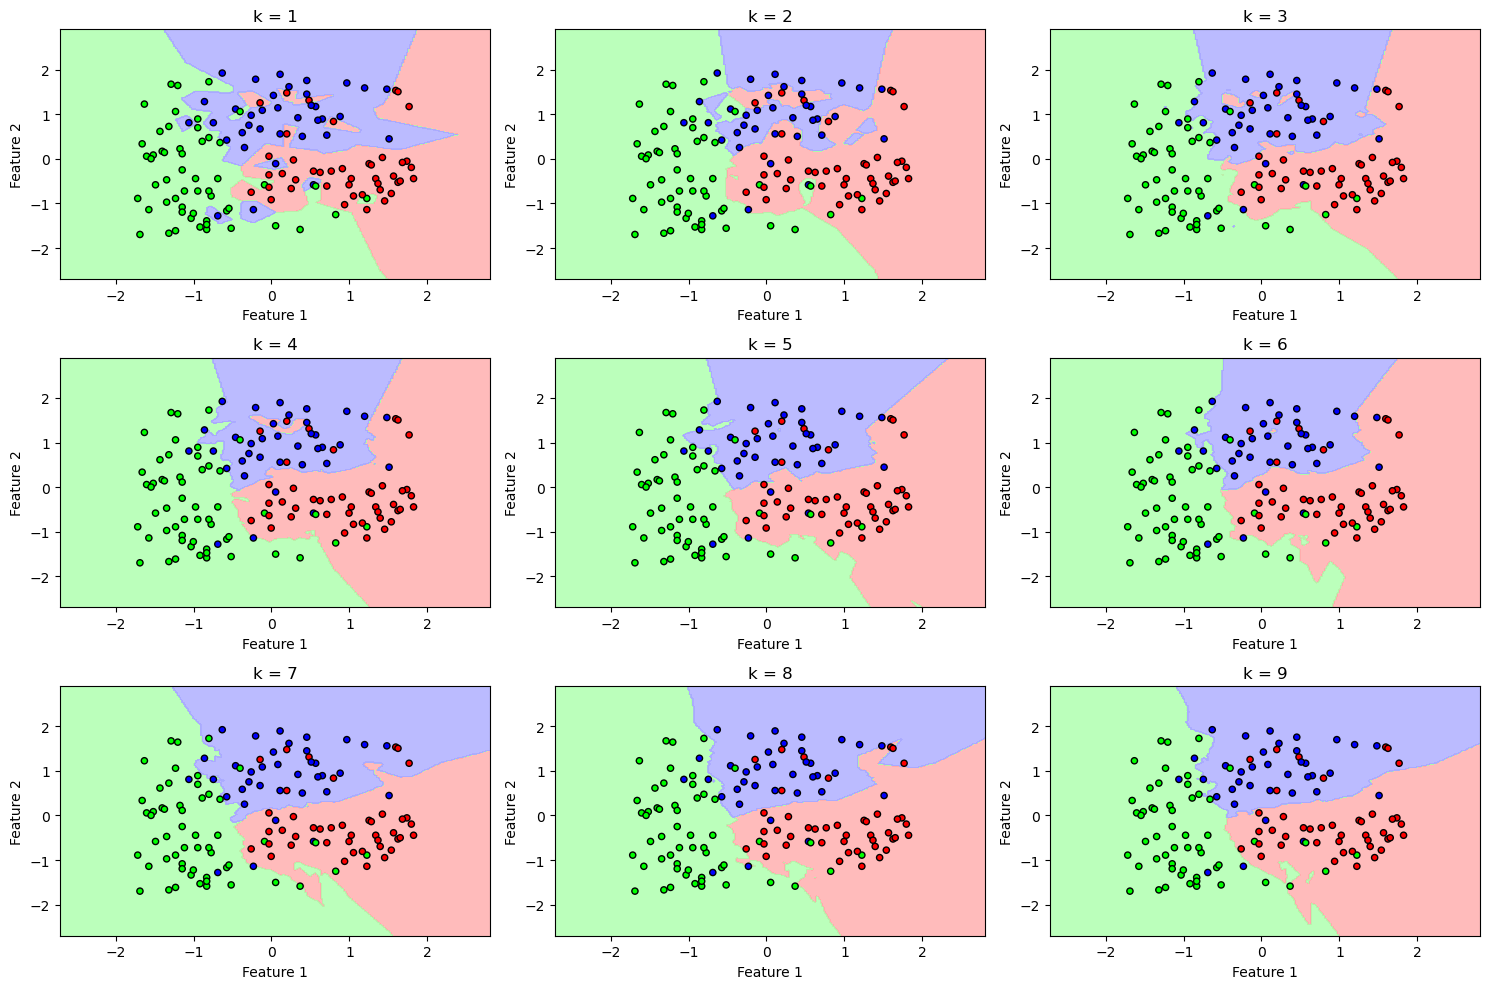

In [80]:
# Define the range of neighbors from 1 to 10
neighbors = np.arange(1, 10)

# Initialize empty arrays to store training and test accuracy for each number of neighbors
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Create a meshgrid for visualization
h = .02  # Step size in the mesh
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure(figsize=(15, 10))

# Loop through each neighbor value
for i, k in enumerate(neighbors, start=1):
    # Setup a k-nearest neighbors classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model using the training data
    knn.fit(X_train[:, :2], y_train)  # Use only the first 2 features
    
    # Compute accuracy on the training set
    train_accuracy[i - 1] = knn.score(X_train[:, :2], y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i - 1] = knn.score(X_test[:, :2], y_test)
    
    # Plot decision boundary
    plt.subplot(3, 3, i)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    
    # Plot training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'k = {k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Performance Analysis

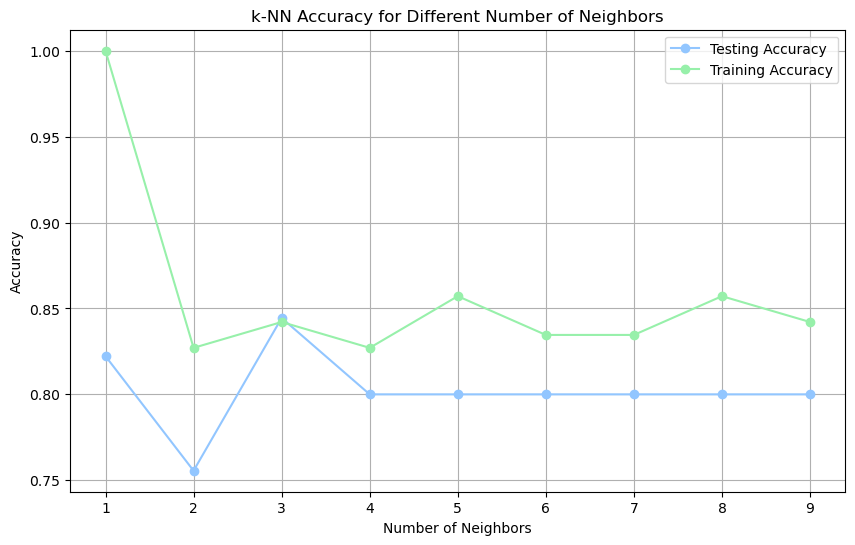

In [81]:
# Plotting test accuracy to find the optimal k
plt.figure(figsize=(10, 6))  # Set figure size for better visualization

plt.title('k-NN Accuracy for Different Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', marker='o')  # Plot testing accuracy
plt.plot(neighbors, train_accuracy, label='Training Accuracy', marker='o')  # Plot training accuracy

plt.legend()  # Add legend to the plot
plt.xlabel('Number of Neighbors')  # Set label for x-axis
plt.ylabel('Accuracy')  # Set label for y-axis
plt.xticks(neighbors)  # Set ticks on x-axis to match the number of neighbors
plt.grid(True)  # Add grid to the plot for better readability

plt.show()  # Display the plot

Accuracy the best for k = 8.

In [82]:
start = time.time()

#instantiate the model
knn = KNeighborsClassifier(n_neighbors=8)

#fit the model with data
knn.fit(X_train, y_train)

end = time.time()
knn_time = end-start
print('Train Time of KNN:',knn_time)

y_pred_knn = knn.predict(X_test)

Train Time of KNN: 0.0014491081237792969


In [83]:
# Compute and print the accuracy score
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

Accuracy: 0.9777777777777777


Text(0.5, 427.9555555555555, 'Predicted Label')

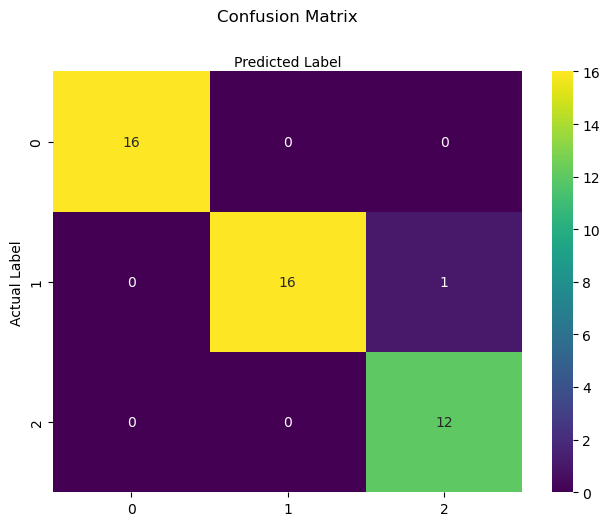

In [84]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Define the class names
class_names = ['Class 1', 'Class 2', 'Class 3']

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Create tick marks for the classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Plot the heatmap with annotations
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="viridis", fmt='g')

# Set the label position
ax.xaxis.set_label_position("top")

# Adjust layout and set title and labels
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

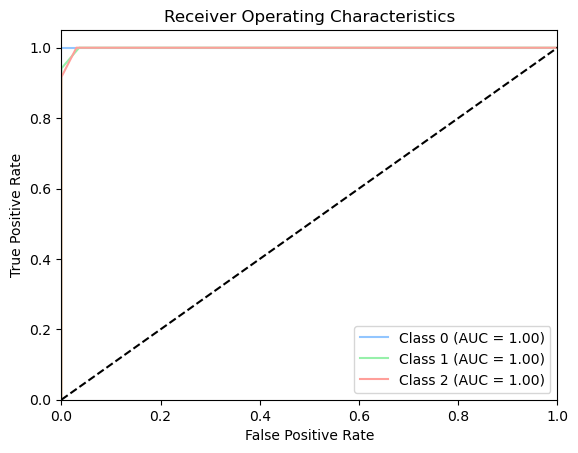

In [85]:
# Generate predictions
y_pred_prob = knn.predict_proba(X_test)

# Binarize the labels using the OvR strategy
y_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(y_bin.shape[1]):  # Loop over each class
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Set the limits for the x-axis and y-axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the label for the x-axis
plt.xlabel('False Positive Rate')

# Set the label for the y-axis
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristics')

# Display the legend at the lower right corner
plt.legend(loc="lower right")

# Show the plot
plt.show()


In [86]:
# Instantiate the KNeighborsRegressor model with 8 neighbors
knn_model = KNeighborsRegressor(n_neighbors=8)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Make predictions on the training data
train_preds = knn_model.predict(X_train)

# Calculate the mean squared error (MSE) between the actual and predicted values on the training data
mse = mean_squared_error(y_train, train_preds)

# Calculate the root mean squared error (RMSE) from the MSE
rmse = np.sqrt(mse)

# Print the training RMSE
print("Training Root Mean Squared Error:", rmse)

Training Root Mean Squared Error: 0.19449665130387478


In [87]:
# Make predictions on the testing data
test_preds = knn_model.predict(X_test)

# Calculate the mean squared error (MSE) between the actual and predicted values on the testing data
mse = mean_squared_error(y_test, test_preds)

# Calculate the root mean squared error (RMSE) from the MSE
rmse = np.sqrt(mse)

# Print the testing RMSE
print('Testing Root Mean Squared Error:', rmse)

Testing Root Mean Squared Error: 0.16666666666666666


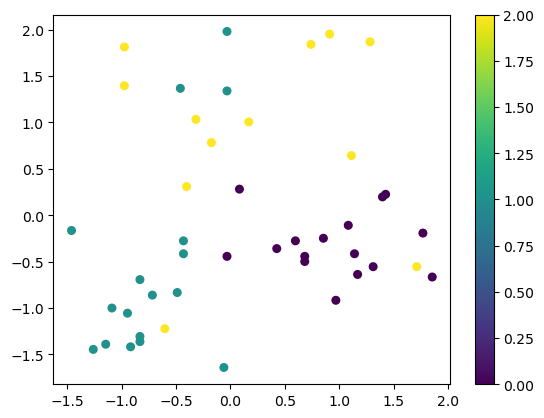

In [89]:
# Create a color map (cmap) using the "viridis" colormap from seaborn
cmap = sns.color_palette("viridis", as_cmap=True)

# Create a scatter plot with the testing data
f, ax = plt.subplots()

# Scatter plot the features (X_test) against each other, with colors representing the target labels (y_test)
# The size of the points is set to 30
# The colormap (cmap) is used to assign colors to different classes
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, cmap=cmap)

# Add a color bar to the plot to show the mapping of colors to target labels
cbar = f.colorbar(points)